In [1]:
from IPython.display import clear_output
import os,cv2,random,torch,torchvision
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
AllClasses = ['Markov',
              'Non-Markov']


class DataProcess(torch.utils.data.Dataset):
    def __init__(self, ImagesPath, ImageTransformer):
        global AllClasses
        def GetImage(Class):
            images = [x for x in os.listdir(ImagesPath[Class]) if x[-3:].lower().endswith('jpg') or x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {Class} examples')
            return images
        
        self.images = {}
        self.Classes = AllClasses
        
        for Class in self.Classes:
            self.images[Class] = GetImage(Class)
            
        self.ImagesPath = ImagesPath
        self.ImageTransformer = ImageTransformer
    def __len__(self):
        return sum([len(self.images[Class]) for Class in self.Classes])
    def __getitem__(self, index):
        Class = random.choice(self.Classes)
        index = index % len(self.images[Class])
        NameOfPicture = self.images[Class][index]
        PathOfPicture = os.path.join(self.ImagesPath[Class], NameOfPicture)
        image = Image.open(PathOfPicture).convert('RGB')
        
        return self.ImageTransformer(image), self.Classes.index(Class)

def AccCalc(LabelsValues,OutputValues) : 
  _,PredictedValues = torch.max(OutputValues, 1)
  return sum((PredictedValues == LabelsValues).numpy())

In [3]:
AllImages = {}
SavedImages = 0
Path = 'E:/end/Data-M'
for folder in os.listdir(Path) : 
  ThisPath = os.path.join(Path,folder)
  AllImages[folder] = []
  for image in os.listdir(ThisPath) : 
    SavedImages+=1
    AllImages[folder].append(os.path.join(ThisPath,image))
AllImages

{'Markov': ['E:/end/Data-M\\Markov\\A (1).jpg',
  'E:/end/Data-M\\Markov\\A (10).jpg',
  'E:/end/Data-M\\Markov\\A (100).jpg',
  'E:/end/Data-M\\Markov\\A (1000).jpg',
  'E:/end/Data-M\\Markov\\A (1001).jpg',
  'E:/end/Data-M\\Markov\\A (1002).jpg',
  'E:/end/Data-M\\Markov\\A (1003).jpg',
  'E:/end/Data-M\\Markov\\A (1004).jpg',
  'E:/end/Data-M\\Markov\\A (1005).jpg',
  'E:/end/Data-M\\Markov\\A (1006).jpg',
  'E:/end/Data-M\\Markov\\A (1007).jpg',
  'E:/end/Data-M\\Markov\\A (1008).jpg',
  'E:/end/Data-M\\Markov\\A (1009).jpg',
  'E:/end/Data-M\\Markov\\A (101).jpg',
  'E:/end/Data-M\\Markov\\A (1010).jpg',
  'E:/end/Data-M\\Markov\\A (1011).jpg',
  'E:/end/Data-M\\Markov\\A (1012).jpg',
  'E:/end/Data-M\\Markov\\A (1013).jpg',
  'E:/end/Data-M\\Markov\\A (1014).jpg',
  'E:/end/Data-M\\Markov\\A (1015).jpg',
  'E:/end/Data-M\\Markov\\A (1016).jpg',
  'E:/end/Data-M\\Markov\\A (1017).jpg',
  'E:/end/Data-M\\Markov\\A (1018).jpg',
  'E:/end/Data-M\\Markov\\A (1019).jpg',
  'E:/end/Dat

In [4]:
len(AllImages.keys()),SavedImages

(2, 48000)

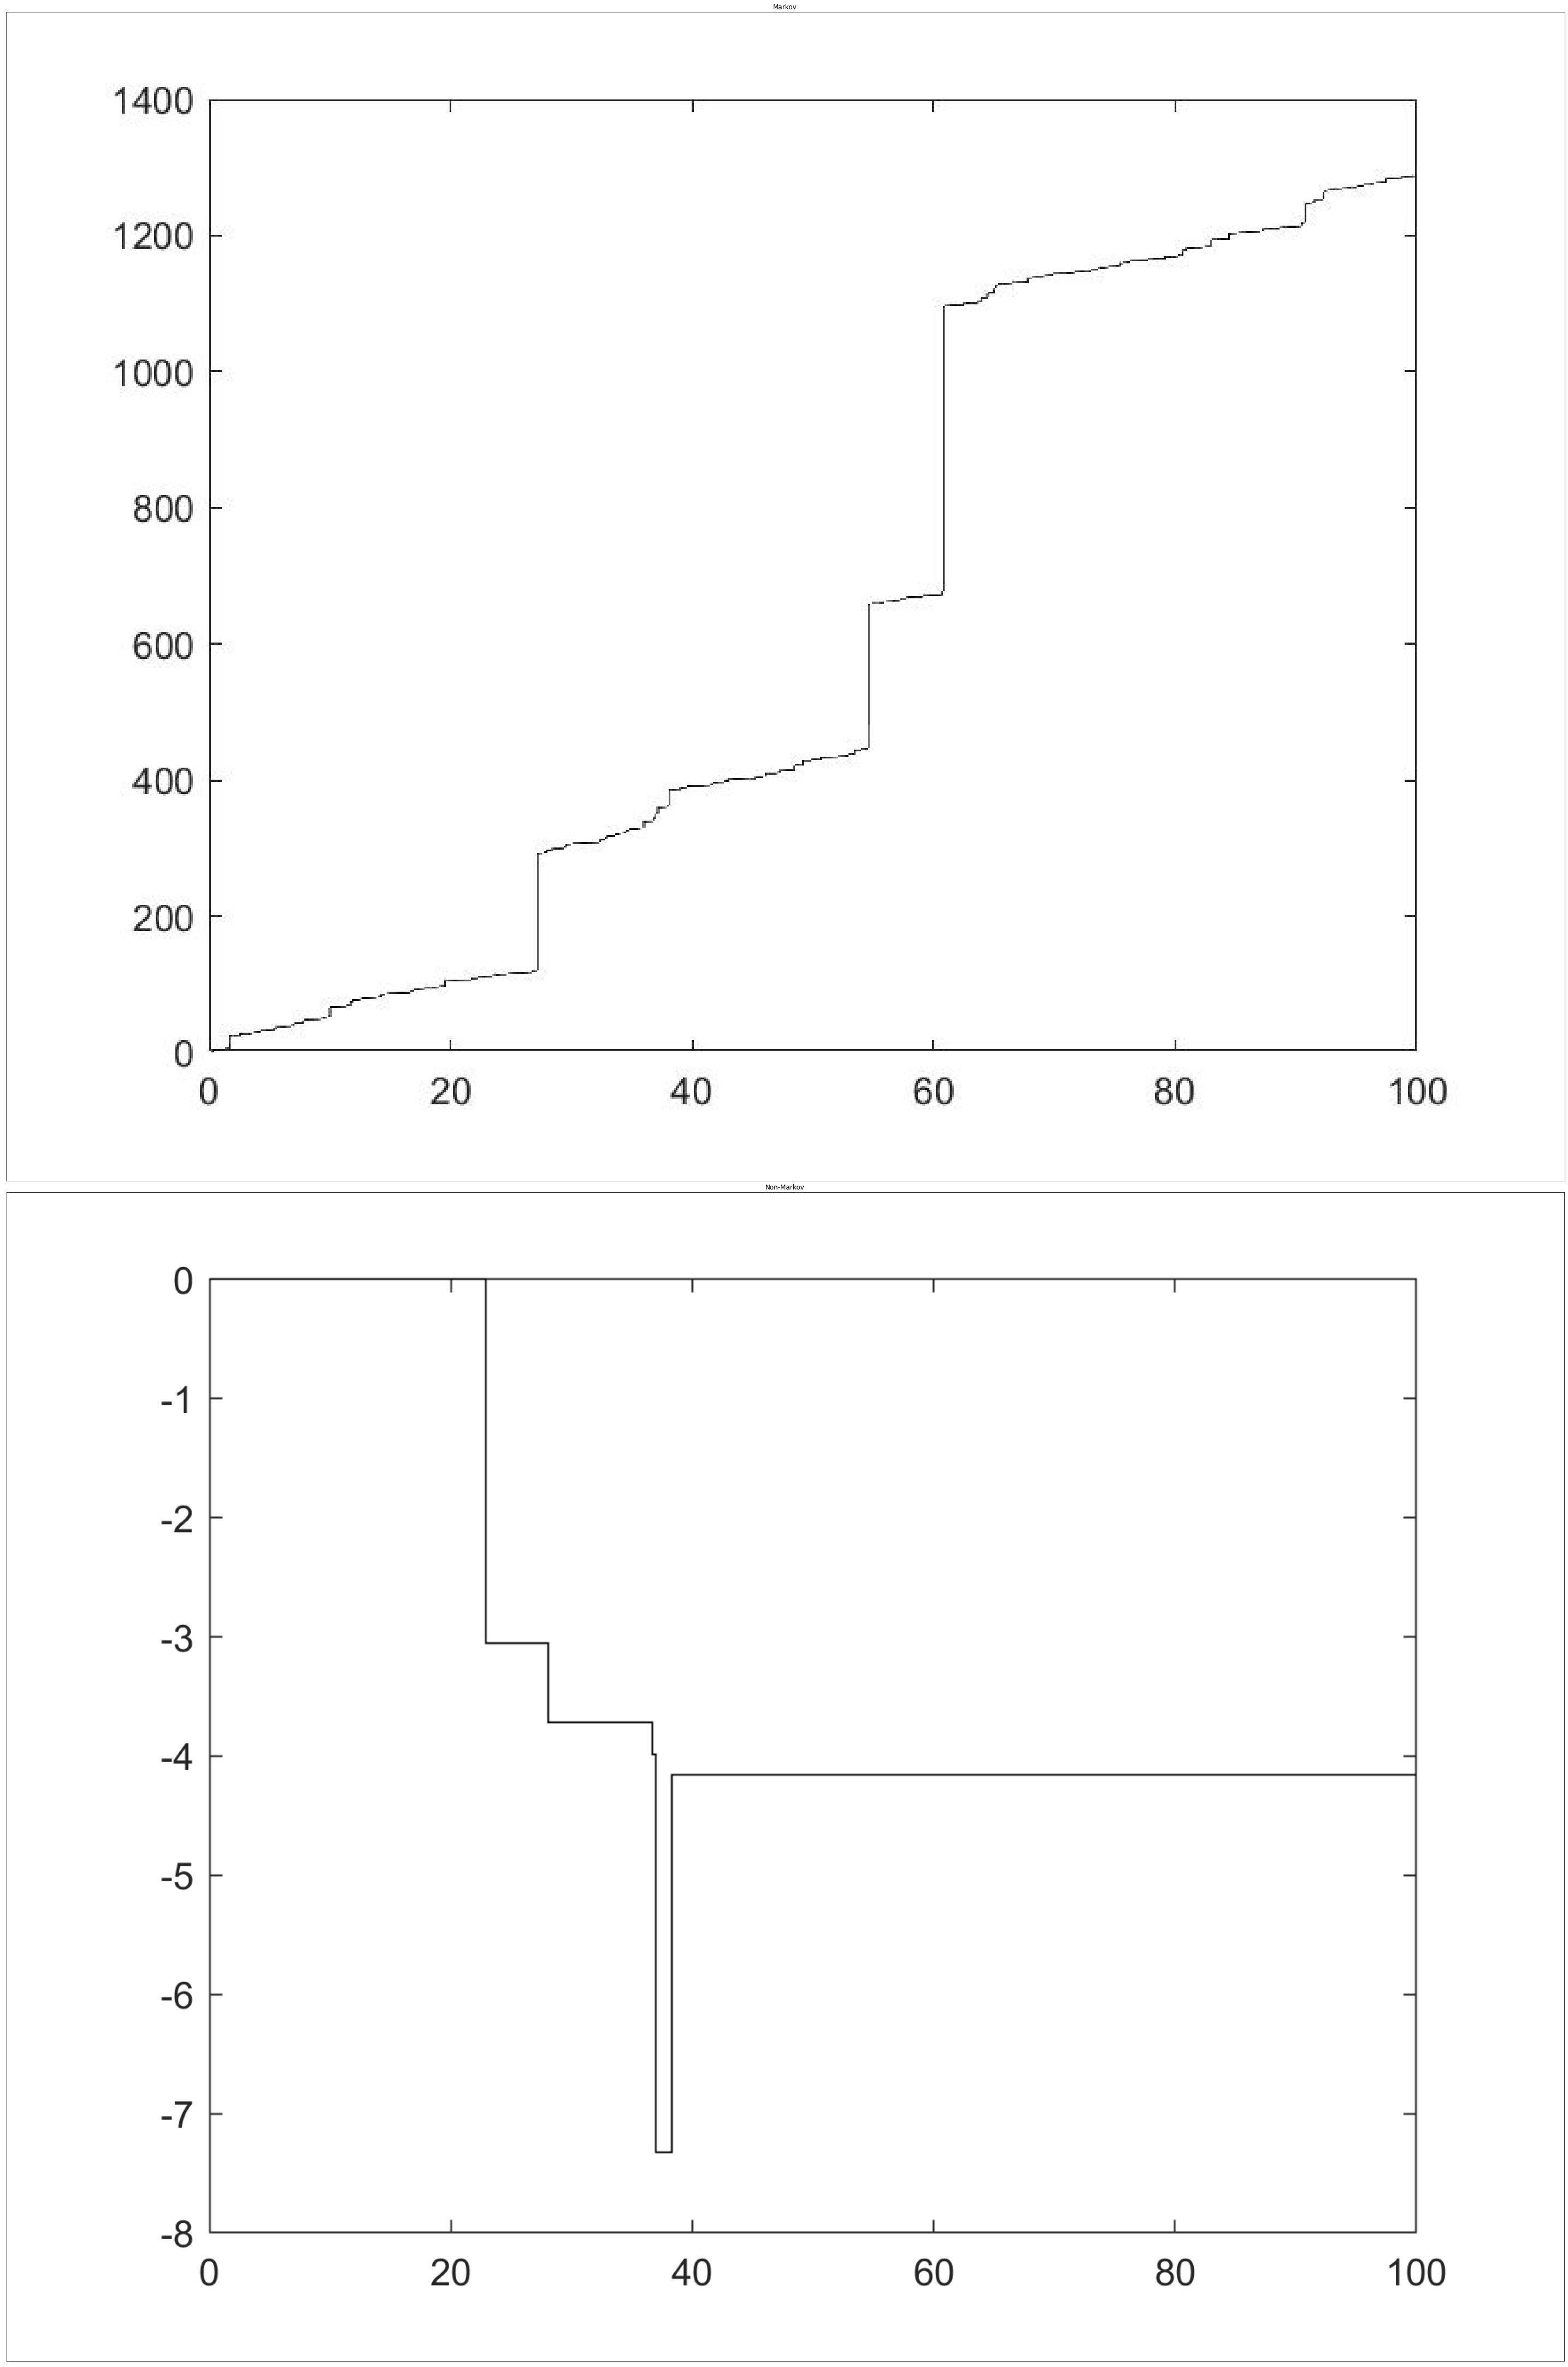

In [5]:
def ShowImages() : 
  global AllImages

  fig, ax = plt.subplots(2, 1, figsize=(80,60))  
  fig.tight_layout(pad=0.010)
  for i in range(len(ax)): 
    im = np.random.choice(AllImages[list(AllImages.keys())[i]])
    ax[i].imshow(plt.imread(im))
    ax[i].set_title(list(AllImages.keys())[i])

  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
ShowImages()

In [6]:
SavedImages,TrainingDataSize,TestingDataSize=0,0,0
ThisModel,ThisLossFunction ,ThisOptimizer = None,None,None
ThisTransformer = torchvision.transforms.Compose([torchvision.transforms.Resize(size=(50,50)),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor()])

In [7]:
ImagesPath = {i:os.path.join(r'E:/end/Data-M',i) for i in AllClasses}

ProcessedData = DataProcess(ImagesPath, ThisTransformer)

TrainingDataSize = 0.8

TrainingSize = int(TrainingDataSize * len(ProcessedData))
TestingSize = len(ProcessedData) - TrainingSize

TrainingData, TestingData = torch.utils.data.random_split(ProcessedData, [TrainingSize, TestingSize])
TrainingDataSize,TestingDataSize=len(TrainingData), len(TestingData)
print("Length of train set   :  ", len(TrainingData))
print("Length of test set    :  ", len(TestingData))


Found 16000 Markov examples
Found 32000 Non-Markov examples
Length of train set   :   38400
Length of test set    :   9600


In [8]:
BatchSize = 10

TrainingDataLength = torch.utils.data.DataLoader(TrainingData, batch_size = BatchSize, shuffle = True)
TestingDataLength = torch.utils.data.DataLoader(TestingData, batch_size=BatchSize, shuffle=True)


print("Length of training batches", len(TrainingDataLength))
print("Lentgth of test batches", len(TestingDataLength))


Length of training batches 3840
Lentgth of test batches 960


In [9]:
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.00001)  

For Epoch Number 30
---------------------------------------------
Train Loss is 0.0 & Train Accuracy is 1.0 
Test Loss is 0.0 & Test Accuracy is 1.0


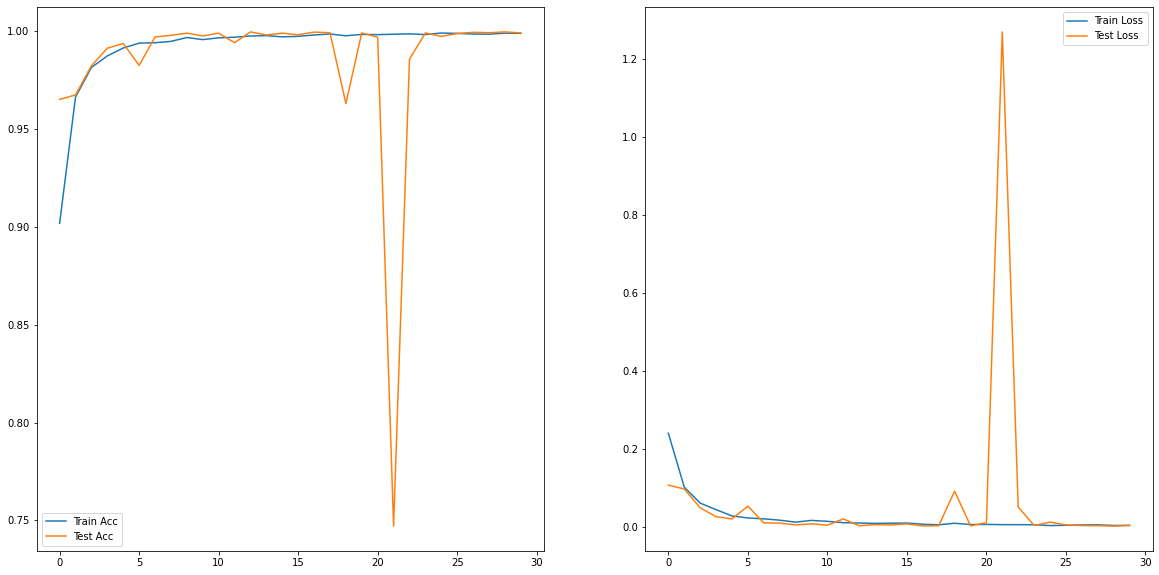

Wall time: 14h 42min 35s


In [11]:
%%time
NumberOfEpochs = 30
ThisModel = resnet18
 
ThisOptimizer = optimizer

ThisLossFunction=loss_fn

AccuracyTraining,AccuracyTesting,LossTraining,LossTesting = [],[],[],[]
for j in range(NumberOfEpochs):
  print(j)
  TrainLoss,TestLoss,TrainAccuracy,TestAccuracy  = 0,0,0,0
  ThisModel.train()
  i=0
  for X,y in TrainingDataLength:
    i+=1
    ThisOptimizer.zero_grad()
    ThisOutput = ThisModel(X)
    ThisLoss = ThisLossFunction(ThisOutput,y)
    ThisLoss.backward()
    ThisOptimizer.step()
    TrainLoss += ThisLoss.item()
    TrainAccuracy += AccCalc(y,ThisOutput)
  TrainLoss /=i
  TrainAccuracy /=TrainingDataSize
  
  AccuracyTraining.append(TrainAccuracy)
  LossTraining.append(TrainLoss)
  
  ThisModel.eval()
  i=0
  for X,y in TestingDataLength:
    i+=1
    ThisOutput = ThisModel(X)
    ThisLoss = ThisLossFunction(ThisOutput,y)
    TestLoss += ThisLoss.item()
    TestAccuracy += AccCalc(y,ThisOutput)
  
  TestLoss/=i
  TestAccuracy /=TestingDataSize
  AccuracyTesting.append(TestAccuracy)
  LossTesting.append(TestLoss)
  
  clear_output(wait=True)
  print(f'For Epoch Number {j+1}')
  print('---------------------------------------------')
  print(f'Train Loss is {np.round(TrainLoss,2)} & Train Accuracy is {np.round(TrainAccuracy,2)} ')
  print(f'Test Loss is {np.round(TestLoss,2)} & Test Accuracy is {np.round(TestAccuracy,2)}')
  torch.save(ThisModel, f"E:/end/code/M-18-30-Yes/M-18-30-Yes")
  plt.figure(figsize=(20,10))
  XValue = [k for k in range(j+1)]
  plt.subplot(1,2,1)
  plt.plot(XValue,AccuracyTraining,label='Train Acc')
  plt.plot(XValue,AccuracyTesting,label='Test Acc')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(XValue,LossTraining,label='Train Loss')
  plt.plot(XValue,LossTesting,label='Test Loss')
  plt.legend()
  plt.show()

In [12]:
ThisModel = torch.load('E:/end/code/M-18-30-Yes/M-18-30-Yes')

In [13]:
i=0
AllYValue,AllOutput = [],[]
ThisModel.eval()
ThisLossFunction = torch.nn.CrossEntropyLoss()
TestLoss,TestAccuracy  = 0,0
for X,y in TestingDataLength:
  i+=1
  # if i ==50 : break
  if i%50==0 : print(i)
  ThisOutput = ThisModel(X)
  AllYValue.extend(y)
  _,PredictedValues = torch.max(ThisOutput, 1)
  AllOutput.extend([int(i) for i in PredictedValues])
  ThisLoss = ThisLossFunction(ThisOutput,y)
  TestLoss += ThisLoss.item()
  TestAccuracy += AccCalc(y,ThisOutput)
z=0
for a,b in zip(AllOutput,[int(i) for i in AllYValue]) : 
  if a==b : z+=1
z/len(AllOutput)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


0.9997916666666666

In [14]:
TestLoss/i,TestAccuracy/i*0.10

(0.0011137357411456605, 0.9997916666666667)

In [15]:
print(f'Model Accuracy is {np.round(TestAccuracy/i*0.10,2)} and loss is {np.round(TestLoss/i,2)}')

Model Accuracy is 1.0 and loss is 0.0


In [16]:
AllYValue = [int(i) for i in AllYValue]

In [17]:
from sklearn.metrics import classification_report,confusion_matrix
confusion_matrix(AllOutput,AllYValue)

array([[4800,    1],
       [   1, 4798]], dtype=int64)

In [18]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import itertools
import numpy as np

In [19]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):


    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Reds')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

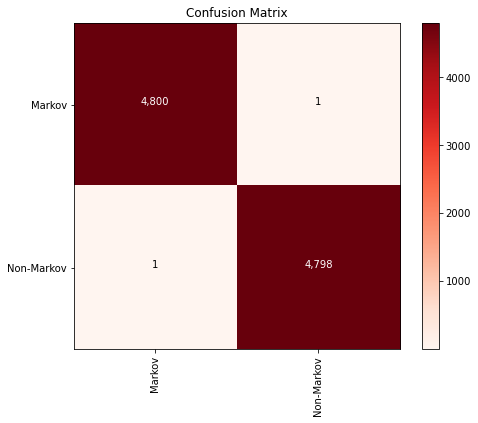

In [20]:
conf_matrix =[[4800,    1],
       [   1, 4798]]
Calss_Names = ['Markov',
              'Non-Markov']
plot_confusion_matrix(cm = np.array(conf_matrix),
                      normalize    = False,
                      target_names = Calss_Names,
                      title   ="Confusion Matrix")


In [21]:
print(classification_report(AllOutput,AllYValue))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4801
           1       1.00      1.00      1.00      4799

    accuracy                           1.00      9600
   macro avg       1.00      1.00      1.00      9600
weighted avg       1.00      1.00      1.00      9600

